# Deep Learning HW1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from math import log
import math
import time

In [2]:
test = np.load('test.npz',mmap_mode='r')
train = np.load('train.npz',mmap_mode='r')
#test.files

train_img = train['image']
y_train = train['label']
test_img = test['image']
y_test = test['label']


print('訓練集有:',len(y_train),'筆資料')
print('測試集有:',len(y_test),'筆資料')


訓練集有: 51000 筆資料
測試集有: 7954 筆資料


In [3]:
def img_preprocess(data):
    #先normalize圖片 (divided by 255)
    data = data/255
    #flatten img
    data2 = []
    for i in range(len(data)):
        data2.append(data[i].flatten())
    return data2

In [9]:
x_test = img_preprocess(test_img)
x_train = img_preprocess(train_img)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test =np.array(y_test)

print('訓練集有:',len(x_train),'張')
print('每張的維度(向量):',len(x_train[0]))

print('測試集有:',len(x_test),'張')
print('每張的維度(向量):',len(x_test[0]))



訓練集有: 51000 張
每張的維度(向量): 1024
測試集有: 7954 張
每張的維度(向量): 1024


In [4]:

        
#Create Hidden Layer
def create_NN(layers):
    weights = []
    #biases = []

    for i in range(len(layers)-1):
        w =  np.random.randn(layers[i], layers[i+1]) * 0.0
        #b = np.ones((1, layers[i+1]))
        weights.append(w)
        #biases.append(b)
    return weights #,biases  

#Activation Function
def ReLU(inputs):
    return np.maximum(0,inputs)
  
def Softmax(inputs):
    exp_values = np.exp(inputs - np.max(inputs, axis=1,keepdims=True))
    return exp_values / np.sum(exp_values, axis=1,keepdims=True)
    
    
#Cross entropy calculate function
def cross_entropy_loss(y_predict, y_true):
    #y_true = np.array(pd.get_dummies(y_true))
    y_true = np.eye(6)[y_true]
    return -np.sum(y_true * np.log(y_predict+0.00001))/ len(y_true)  #add 0.00001 to prevent zero in np.log

#calculate derivative of softmax、relu for backpropagation
def softmax_loss(y_predict,y_true):
        m = len(y_predict)
        dz = y_predict.copy()
        # Calculate gradient
        dz[range(m), y_true] -= 1
        
        return dz / m

def de_ReLU(Z):
    Z[Z <= 0] = 0
    return Z


def forward(X,weights):
    z_list = []
    a_list = []
    
    for i in range(len(weights)):
        if i == 0:  #input layer
            z_list.append(np.dot(X, weights[i]))# + biases[i])
            a_list.append(ReLU(z_list[i]))
            
        elif i != len(weights) and i!=(len(weights)-1):  #hidden layer
            z_list.append(np.dot(a_list[i-1], weights[i]) )#+ biases[i])
            a_list.append(ReLU(z_list[i]))
            
        elif i == (len(weights)-1):  #output layer
            
            z_list.append(np.dot(a_list[i-1], weights[i]) )#+ biases[i])
            a_list.append(Softmax(z_list[i]))
  
    
    
    
    return z_list,a_list



In [17]:

def mini_SGD(layers,epochs,batch_size,lr,*args):
    
    #epochs = 10
    #batch_size = 50
    batch_num = math.ceil(len(x_train)/batch_size)
    #lr=0.01

    #get initial weight and biases
    if args:
        weights=[]
        print('---Using weights given by TAs---')
        for item in args[0]:
            weights.append(item)
        
    else:
        print('---Random initial weight---')
        weights = create_NN(layers)
        
    print('Learning rate:',lr)
    print('batch size:', batch_size)
    print('Total epochs:', epochs)
    
    
    #accuracy、loss for train and test data
    acc_list = [[],[]]
    loss_list = [[],[]]
    print('begin training...')
    for epoch in range(epochs):
        for i in range(batch_num):
            x_train_batch = x_train[i*batch_size : (i+1)*batch_size]
            y_train_batch = y_train[i*batch_size : (i+1)*batch_size]

            #Feed fordward Here
            z_list, a_list = forward(x_train_batch,weights)
            
            z_list_train, a_list_train = forward(x_train,weights) 
            z_list_test, a_list_test = forward(x_test[:],weights)
            
            #計算Loss
            #train_loss = cross_entropy_loss(a_list[-1] , y_train_batch)
            train_loss = cross_entropy_loss(a_list_train[-1] , y_train)
            test_loss = cross_entropy_loss(a_list_test[-1] , y_test[:])

            #每行機率算出來最大值就是分類結果(用argmax 取其index)
            #predictions = np.argmax(a_list[-1], axis=1)
            train_predictions = np.argmax(a_list_train[-1],axis=1)
            test_predictions = np.argmax(a_list_test[-1], axis=1)

            #計算ACC 計算所有成功估計的個數佔整體平均
            #accuracy = np.mean(predictions==y_train_batch)
            accuracy = np.mean(train_predictions==y_train)
            test_acc = np.mean(test_predictions==y_test[:])

            acc_list[0].append(accuracy)
            acc_list[1].append(test_acc)

            loss_list[0].append(train_loss)
            loss_list[1].append(test_loss)


            if not epoch%1:
                if not i % batch_num:
                    print('【Epoch',epoch,'】:',end='')
                    print('Train Accuracy: %.3f' %accuracy ,end='')
                    print(', Train Loss: %.3f' %train_loss,end='')
                    print(' Test Accuracy: %.3f' %test_acc ,end='')
                    print(', Test Loss: %.3f' %test_loss)
                    print('')

            
            ###############################BACKPROPAGATION#######################################
            #prediction : a_list[-1]
            #y_true : y_train_batch

            m = len(y_train_batch)
            dw_list = []
            db_list = []

            for i in range(len(weights)-1,-1,-1):
                if i == len(weights)-1:               #output layer
                    dz = softmax_loss(a_list[-1], y_train_batch)
                    dw_list.insert(0, 1/m * np.dot(a_list[i-1].T, dz))
                    #db_list.insert(0, 1/m * np.sum(dz,axis=0,keepdims=True))

                elif i != len(weights) and  i!=0:     #hidden layer
                    dz = np.dot(dz,  weights[i+1].T) * de_ReLU(z_list[i])
                    dw_list.insert(0, 1/m * np.dot(a_list[i-1].T, dz))
                    #db_list.insert(0, 1/m * np.sum(dz,axis=0,keepdims=True))

                elif i == 0:                          #input layer
                    dz = np.dot(dz, weights[i+1].T) * de_ReLU(z_list[i])
                    dw_list.insert(0, 1/m * np.dot(x_train_batch.T, dz))
                    #db_list.insert(0, 1/m * np.sum(dz,axis=0,keepdims=True))


            ############################Update weights and biases###################################

            for i in range(len(weights)):
                weights[i] -= lr * dw_list[i]
                
    #############################PLOT#########################
    
    plt.figure(figsize=(10,5))
    plt.plot(acc_list[0],label='Training ACC')
    plt.plot(acc_list[1],label='Testing ACC')
    plt.title('Learning Curve')
    plt.xlabel('iterations')
    plt.ylabel('ACC')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(loss_list[0],label='Training Loss')
    plt.plot(loss_list[1],label='Testing Loss')
    plt.title('Learning Curve (Loss)')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    print('training success')

## HW1-1 (a)

### Plot the learning curves of J(w) and the accuracy

模型設計:

Hidden layer1: 64 nodes，

Hidden layer2: 32 nodes，

output layer:  6 nodes。

Epoch number = 20，
Batch size = 2048，
Learning rate = 0.8。

在前四個epoch Acc迅速爬升，並在第14、15epoch之後，Accuracy逐漸收斂到80%以上。

---Random initial weight---
Learning rate: 0.8
batch size: 2048
Total epochs: 20
【Epoch 0 】:Train Accuracy: 0.167, Train Loss: 9.541 Test Accuracy: 0.189, Test Loss: 9.302

【Epoch 1 】:Train Accuracy: 0.397, Train Loss: 3.701 Test Accuracy: 0.436, Test Loss: 3.102

【Epoch 2 】:Train Accuracy: 0.542, Train Loss: 2.643 Test Accuracy: 0.584, Test Loss: 2.183

【Epoch 3 】:Train Accuracy: 0.602, Train Loss: 2.091 Test Accuracy: 0.645, Test Loss: 1.759

【Epoch 4 】:Train Accuracy: 0.649, Train Loss: 1.733 Test Accuracy: 0.690, Test Loss: 1.498

【Epoch 5 】:Train Accuracy: 0.684, Train Loss: 1.489 Test Accuracy: 0.718, Test Loss: 1.322

【Epoch 6 】:Train Accuracy: 0.712, Train Loss: 1.315 Test Accuracy: 0.738, Test Loss: 1.193

【Epoch 7 】:Train Accuracy: 0.733, Train Loss: 1.186 Test Accuracy: 0.755, Test Loss: 1.096

【Epoch 8 】:Train Accuracy: 0.749, Train Loss: 1.088 Test Accuracy: 0.771, Test Loss: 1.020

【Epoch 9 】:Train Accuracy: 0.762, Train Loss: 1.011 Test Accuracy: 0.783, Test Loss: 0.960


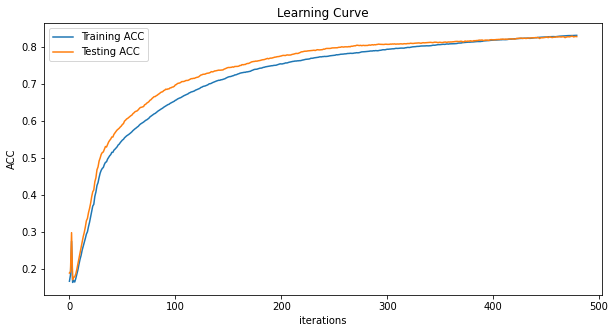

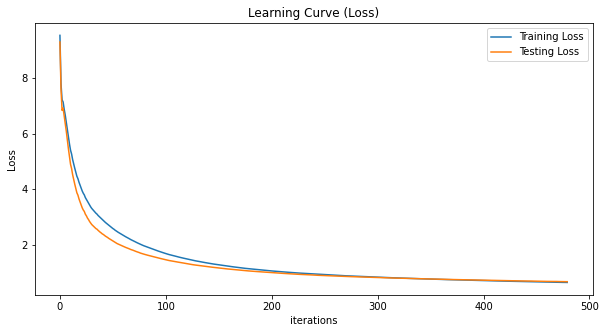

elapsed time: 114.90426230430603 s


In [38]:

layers = [1024,64,32,6]
start = time.time()
mini_SGD(layers,20,2048,0.8)

print('elapsed time:',time.time()-start,'s')

## HW1-1 (b)

### Repeat 1(a) by using different batch sizes. (batch size = 1024)

使用同(a)的模型設計，將batch size 改成1024，訓練相較前一題花了將近兩倍的時間。

模型訓練在前3個epoch Acc迅速爬升，到了第15個epoch 之後可以收斂到Accuracy 90%以上，但後面有些震盪不穩，在Acc有時下探到80%甚至是70%。


---Random initial weight---
Learning rate: 0.8
batch size: 1024
Total epochs: 20
【Epoch 0 】:Train Accuracy: 0.167, Train Loss: 9.571 Test Accuracy: 0.190, Test Loss: 9.319

【Epoch 1 】:Train Accuracy: 0.624, Train Loss: 1.962 Test Accuracy: 0.595, Test Loss: 2.054

【Epoch 2 】:Train Accuracy: 0.748, Train Loss: 1.058 Test Accuracy: 0.718, Test Loss: 1.066

【Epoch 3 】:Train Accuracy: 0.812, Train Loss: 0.774 Test Accuracy: 0.777, Test Loss: 0.826

【Epoch 4 】:Train Accuracy: 0.834, Train Loss: 0.662 Test Accuracy: 0.800, Test Loss: 0.767

【Epoch 5 】:Train Accuracy: 0.860, Train Loss: 0.562 Test Accuracy: 0.824, Test Loss: 0.666

【Epoch 6 】:Train Accuracy: 0.875, Train Loss: 0.499 Test Accuracy: 0.836, Test Loss: 0.603

【Epoch 7 】:Train Accuracy: 0.884, Train Loss: 0.461 Test Accuracy: 0.842, Test Loss: 0.562

【Epoch 8 】:Train Accuracy: 0.888, Train Loss: 0.442 Test Accuracy: 0.842, Test Loss: 0.557

【Epoch 9 】:Train Accuracy: 0.885, Train Loss: 0.450 Test Accuracy: 0.838, Test Loss: 0.592


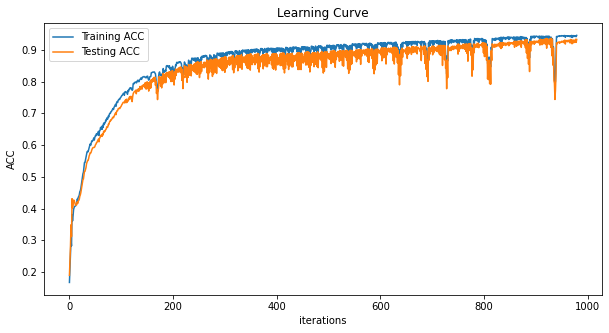

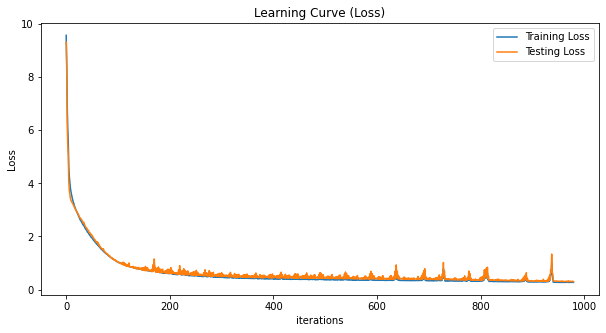

elapsed time: 226.38148403167725 s


In [46]:

layers = [1024,64,32,6]
start = time.time()
mini_SGD(layers,20,1024,0.8)

print('elapsed time:',time.time()-start,'s')

## HW1-1(c)

### Repeat 1(a) by performing zero initialization for the model weights.

使用相同(a)的模型設計，並改用zero initialization 的 weights。

結果是因為weights都是0，加上設計模型沒有biases，input的X資料經過第一層的矩陣相乘之後，所有的值都歸0了，算到最後面，Model無法進行更新，所以也就無法進行訓練，所以ACC和Loss一直都維持在最初的值。

---Random initial weight---
Learning rate: 0.8
batch size: 2048
Total epochs: 20
【Epoch 0 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 1 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 2 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 3 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 4 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 5 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 6 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 7 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 8 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792

【Epoch 9 】:Train Accuracy: 0.167, Train Loss: 1.792 Test Accuracy: 0.189, Test Loss: 1.792


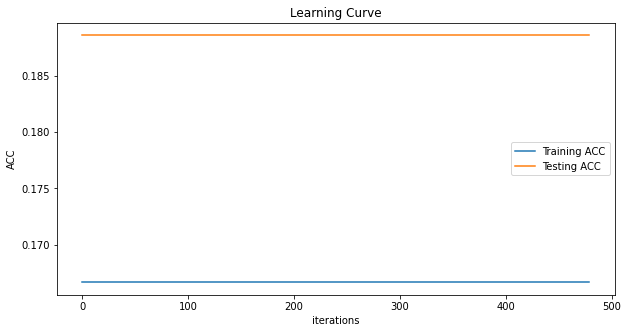

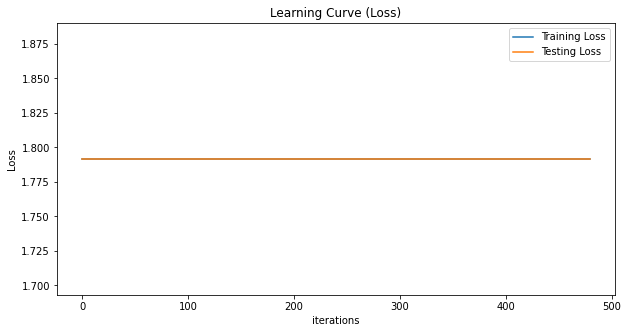

elapsed time: 106.9410183429718 s


In [55]:
# performing zero initialization
#mini_SGD (epoch , batch size , learning rate)
layers = [1024,64,32,6]
start = time.time()
mini_SGD(layers,20,2048,0.8)

print('elapsed time:',time.time()-start,'s')

# Homework 1-2

In [6]:
#讀取助教給定的configuration檔案
def read_config(nn_config):
    layers = []
    for layer in nn_config['nn']:
        layers.append(nn_config['nn'][layer]['input_dim'])
    if layer == 'output':
        layers.append(nn_config['nn'][layer]['output_dim'])
    
    
    epoch = nn_config['epoch']
    lr = nn_config['lr']
    batch_size = nn_config['batch_size']
    
    return layers,epoch,lr,batch_size


def read_weight(weights_raw):
    weights = []

    for weight_layer in weights_raw:
        weights.append(weights_raw[weight_layer])
        
    return weights
    

In [15]:
import argparse
parser = argparse.ArgumentParser()

parser.add_argument('--config', help='config json for fnn')
parser.add_argument('--weight', help='weight for fnn')
parser.add_argument('--imgfilelistname', help='test img name list for fnn')
args = parser.parse_args()

'''
print(args.config)
print(args.weight)
print(args.imgfilelistname)
'''

usage: ipykernel_launcher.py [-h] [--config CONFIG] [--weight WEIGHT] [--imgfilelistname IMGFILELISTNAME]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\kevin\AppData\Roaming\jupyter\runtime\kernel-bc6d6dad-ce86-420c-a476-bce7e71c76dd.json


SystemExit: 2

In [7]:
weights_raw = np.load('weight.npz',mmap_mode='r')

with open("config.json", "r") as read_file:
    nn_config = json.load(read_file)
    
nn_config

{'nn': {'layer1': {'input_dim': 1024, 'output_dim': 2048, 'act': 'relu'},
  'layer2': {'input_dim': 2048, 'output_dim': 512, 'act': 'relu'},
  'output': {'input_dim': 512, 'output_dim': 6, 'act': 'softmax'}},
 'epoch': 20,
 'lr': 0.001,
 'batch_size': 2048,
 'criterion': 'cross_entropy'}

In [16]:
weights_raw = np.load(args.weight,mmap_mode='r')

with open(args.config, "r") as read_file:
    nn_config = json.load(read_file)
    
#nn_config

NameError: name 'args' is not defined

In [10]:
#讀取layer、epoch...設定以及weights

layers,epoch,lr,batch_size = read_config(nn_config)

weights = read_weight(weights_raw)

start = time.time()

mini_SGD(layers,epoch,batch_size,lr,weights)

print('elapsed time:',time.time()-start,'s')

---Using weights given by TAs---
Learning rate: 0.001
batch size: 2048
Total epochs: 20
elapsed time: 165.58106684684753 s


In [10]:
from PIL import Image
import os


In [36]:
#讀取最終測試資料
final_test_img_list = [] 

filename_list = open(args.imgfilelistname, "r")
lines = filename_list.read().splitlines()
 
for line in lines:
    final_test_img = Image.open(line)
    final_test_img_list.append(np.array(final_test_img))
    
    line = filename_list.readline()
 
filename_list.close()



#divide by 255 and flatten img
final_test_img_list = np.array(img_preprocess(np.array(final_test_img_list)))

#對最後測試資料預測
z_list, a_list = forward(final_test_img_list,weights)

final_predictions = np.argmax(a_list[-1], axis=1)

print(final_predictions)

[1 0 4 5 4 1 2 1 2 2 0 0 1 3 1 0 1 0 5 1 2 3 2 5 5 3 4 5 0 4 0 2 5 3 3 4 4
 2 5 0 3 5 2 3 4 5 4 4 2 4 1 0 0 5 0 0 0 1 4 3 0 2 4 4 4 1 4 1 1 3 3 2 0 2
 2 2 3 5 3 4 0 5 4 3 0 3 0 0 4 5 3 4 5 3 5 0 1 5 1 2]


In [12]:
#將結果寫入output.txt裡
output_file = open('output.txt','w')

for predict_result in final_predictions:
    output_file.write(str(predict_result))
    
output_file.close()